# Load Libraries and Functions

In [227]:
# System, Data, Time, and Spec Libraries
import os
import pandas as pd
import time
import random
from datetime import datetime, timedelta
import numpy as np 
from line_profiler import LineProfiler  # Code peformance
profiler = LineProfiler()
import warnings
warnings.filterwarnings('ignore')
import csv
#pd.set_option('display.max_colwidth', None)
import multiprocess as mp
num_cores = mp.cpu_count()

# Data Visualization Libraries
import matplotlib.pyplot as plt
from tabulate import tabulate
import plotly.express as px
import seaborn as sns
#from pandas.io.json import json_normalize  # Older version
from pandas import json_normalize  # Newer version
from pandas.plotting import parallel_coordinates


# Natural Language Processing Libraries
import json
import requests
import xml.etree.ElementTree as ET
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import words
import string
import nltk
from collections import OrderedDict
from nltk.tokenize import word_tokenize
from pandas import json_normalize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.util import ngrams
from nltk.corpus import stopwords
from string import punctuation
punctuation = set(punctuation)
punctuation.update({'_', '-','‘'})
english_words = set(words.words())
from fuzzywuzzy import process
#nltk.download('words')
#nltk.download('punkt')
#nltk.download('stopwords')

# SQL Interface Libraries
import pymysql as mysql
import mysql.connector
import pyodbc
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import event
from string import punctuation

# Machine Learning Libraries
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats import yeojohnson
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay,roc_auc_score, roc_curve 
from sklearn.metrics import classification_report, mean_squared_error, f1_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from dmba import classificationSummary, AIC_score, BIC_score, plotDecisionTree,gainsChart
from scikitplot.metrics import plot_lift_curve, plot_cumulative_gain
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.metrics import specificity_score, sensitivity_score
from imblearn.under_sampling import RandomUnderSampler
from scikitplot.metrics import plot_lift_curve
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import cross_val_score
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
from dmba import stepwise_selection, classificationSummary, backward_elimination
from sklearn.decomposition import PCA
from sklearn.utils.random import sample_without_replacement
from sklearn.metrics import precision_score, recall_score

# Importing Custom Functions
import nbimporter
from Functions import nan_info

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Test Join Outside of Database

In [228]:
df1 = pd.read_csv('C://Users/halee/Downloads/events_table2024.csv')
df2 = pd.read_csv('C://Users/halee/Downloads/drugs_table2024_prep.csv')
# Merge df1 and df2
merged_df1_df2 = pd.merge(df1, df2, on='event_id', how='inner')
merged_df1_df2.drop(['patient_drug_id'], axis = 1, inplace = True)
merged_df1_df2.drop_duplicates(inplace=True)
merged_df1_df2.head(20)

In [241]:
nan_info(merged_df1_df2)

,column_name,null_count,null_proportion
0,event_id,0,0.000000
1,year,0,0.000000
2,expedited,0,0.000000
3,report_source,0,0.000000
4,country,0,0.000000
5,age,0,0.000000
6,sex,0,0.000000
7,weight,0,0.000000
8,serious_outcome,0,0.000000
9,company_name,3738,5.666040


In [242]:
merged_df1_df2['ndc9'] = merged_df1_df2['ndc9'].astype(str)
merged_df1_df2['ndc9'].head()

0     502420040.0
55    502420040.0
82    759870020.0
83      9309224.0
86    502420135.0
Name: ndc9, dtype: object

In [243]:
with_drugs = merged_df1_df2[['event_id', 'expedited', 'age', 'sex', 'weight', 'report_source', 'ndc9', 'serious_outcome']].drop_duplicates(subset='event_id')

In [244]:
with_drugs.head()

,event_id,expedited,age,sex,weight,report_source,ndc9,serious_outcome
0,1,1,39.0,2,112.00,1,502420040.0,1
55,2,1,57.0,1,74.00,1,502420040.0,1
83,3,2,44.0,2,61.22,1,9309224.0,1
86,4,1,65.0,2,57.00,3,502420135.0,1
97,5,1,42.0,2,50.00,3,502420135.0,1


In [245]:
with_drugs.to_csv('C://Users/halee/Downloads/with_drugs_sample2024.csv', index = False)

### SQL Password

In [3]:
PASSWORD  = 'PASSWORD' 

## Investigate number of records in each database table

In [69]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT COUNT(*) FROM patient_reactions"""


cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]


result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

,COUNT(*)
0,112551


# Get Dataset from SQL Database

In [70]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create a cursor object
cursor = connection.cursor()

In [15]:
# # Master Query from Data - goal

# master_query = """SELECT 
#                 a.serious_outcome,
#                 a.expedited,
#                 a.age,
#                 a.sex,
#                 a.year
#                 a.weight
#                 r.outcome,
#                 p.unit_price,
#                 p.generic_brand,
#                 l.ingredients,
#                 l.rxcui,
#                 l.set_id,
#                 d.manu_num,
#                 d.unii
#             FROM adverse_events a 
#                 INNER JOIN patients_reactions r ON a.event_id = r.event_id 
#                 INNER JOIN patients_drugs d ON r.event_id = d.event_id 
#                 INNER JOIN prices p ON d.ndc11 = p.ndc11
#                 INNER JOIN lables l ON p.ndc11 = l.ndc11
#             ORDER BY a.event_id DESC"""  # Still need to test and figure out

# Read in data from csv OR

In [5]:
master_query_df = pd.read_csv('DataLibrary/result_query_df.csv')

# option 2- Read in data from SQL

In [76]:
start_time = time.time()

connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT 
d.med_product,
d.event_id,
d.manu_num,
a.serious_outcome,
a.expedited,
a.age,
a.sex,
a.year,
a.weight,
r.outcome
FROM adverse_events a 

INNER JOIN patient_reactions r ON a.event_id = r.event_id
INNER JOIN patient_drugs d ON a.event_id = d.event_id
ORDER BY a.event_id DESC
"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
master_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()


end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

master_query_df.head(10)


47.15399479866028


,med_product,event_id,manu_num,serious_outcome,expedited,age,sex,year,weight,outcome
0,['stelara'],24685,1,2,1,64,1,2024,72,Fatal
1,['stelara'],24685,1,2,1,64,1,2024,72,Fatal
2,['remicade'],24685,1,2,1,64,1,2024,72,Fatal
3,['cyclosporine'],24685,16,2,1,64,1,2024,72,Fatal
4,['efalizumab'],24685,0,2,1,64,1,2024,72,Fatal
5,['stelara'],24685,1,2,1,64,1,2024,72,Fatal
6,['stelara'],24685,1,2,1,64,1,2024,72,Fatal
7,['remicade'],24685,1,2,1,64,1,2024,72,Fatal
8,['cyclosporine'],24685,16,2,1,64,1,2024,72,Fatal
9,['efalizumab'],24685,0,2,1,64,1,2024,72,Fatal


In [26]:
master_query_df.shape

(99193, 11)

In [27]:
master_query_df.to_csv('DataLibrary/result_query_df.csv')

In [9]:
master_query_df = result_query_df.drop_duplicates()
master_query_df.shape

(99193, 12)

# Make dataset smaller for testing

# Preparation for Data Split

### Define numerical, text, and categorical variables

In [246]:
with_drugs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20885 entries, 0 to 146548
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   event_id         20885 non-null  int64  
 1   expedited        20885 non-null  int64  
 2   age              20885 non-null  float64
 3   sex              20885 non-null  int64  
 4   weight           20885 non-null  float64
 5   report_source    20885 non-null  int64  
 6   ndc9             20885 non-null  object 
 7   serious_outcome  20885 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 1.4+ MB


In [249]:
result_query_df = with_drugs

In [250]:
cats = ['sex', 'expedited', 'report_source']
nums = ['weight', 'age']  # Took out year since data will all be from recent 3 months of data 
drugs = ['ndc9']
all_vars = cats+nums+drugs

#Define outcome as categorical
result_query_df['serious_outcome'] = result_query_df['serious_outcome'].astype('category')

result_query_df.head()

,event_id,expedited,age,sex,weight,report_source,ndc9,serious_outcome
0,1,1,39.0,2,112.00,1,502420040.0,1
55,2,1,57.0,1,74.00,1,502420040.0,1
83,3,2,44.0,2,61.22,1,9309224.0,1
86,4,1,65.0,2,57.00,3,502420135.0,1
97,5,1,42.0,2,50.00,3,502420135.0,1


### Create Transformation Pipeline

### One Hot Encode Drug Names for Full Dataset before Splitting - using NDC9 since there is only one per row

In [ ]:
# need to do 


In [11]:
# # Create a categorical processing pipeline that uses one-hot encoding
# # Dropping binary columns and drop first of each level** NEED TO ADD**
# cat_pipe = Pipeline([('encoder', OneHotEncoder(drop='if_binary'))])

# # Create a numerical processing pipeline that uses skewness correction/center/scale.
# num_pipe = Pipeline([('skew_standardize', PowerTransformer())])

# # Create a text token processing step to vectorize tokens
# #text_pipe = Pipeline([('vector', tf_idf function())])

# # Combine pipeline steps
# all_pipe = ColumnTransformer(
#     transformers=[
#         ('cat', cat_pipe, cats),
#         ('num', num_pipe, nums)
#         # ('text', text_pipe, texts)  # Apply text pipeline if you have text columns
#     ],
#     verbose_feature_names_out=False
# )
# # Verify steps
# all_pipe

# Split Data into Training/Validation/Testing

### Make a Subset of the Dataset for Initial Model Training

In [24]:
#master_query_df = master_query_df.head(5000)

In [251]:
master_query_df = result_query_df

In [252]:
# Split the data into features (X) and the target variable (y).
X = master_query_df[all_vars]

#Define outcome variable
y = master_query_df[['serious_outcome']]

#Split data
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size=0.8, random_state = 2)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state = 2)

In [253]:
X_train.shape, y_train.shape

((16708, 6), (16708, 1))

In [254]:
y_train.value_counts()

serious_outcome
1                  13302
2                   1774
0                   1632
Name: count, dtype: int64

In [255]:
X_val.shape, y_val.shape

((2088, 6), (2088, 1))

In [256]:
X_test.shape, y_test.shape

((2089, 6), (2089, 1))

## Encode Categorical Variables (other than drugs) & Standardize Numerical Variables

In [257]:
#Initialize encoders
encoder = OneHotEncoder(drop='if_binary', handle_unknown='ignore')
scaler = StandardScaler()

In [ ]:
# Fit the encoder on X so all possible categories are captured, even if they are only in training or testing
encoder.fit(X[cats])
scaler.fit(X_train[nums])


In [116]:
def transform_data(data):
    # Apply one-hot encoding to categorical features
    encoded_features = encoder.transform(data[cats])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cats))
    
    # Apply standardization to numerical features
    standardized_features = scaler.transform(data[nums])
    standardized_df = pd.DataFrame(standardized_features, columns=nums)
    
    # Concatenate the standardized numerical features with the encoded categorical features
    return pd.concat([data.drop(cats + nums, axis=1).reset_index(drop=True),
                      standardized_df.reset_index(drop=True),
                      encoded_df.reset_index(drop=True)], axis=1)

In [ ]:
# Apply the transformation to all datasets
X_train_encoded = transform_data(X_train)
X_val_encoded = transform_data(X_val)
X_test_encoded = transform_data(X_test)
X_test_encoded.head()

## Scale Numerical Only Since Sex already Binary (when using limited dataset, "no_drugs_sample)

In [192]:
def transform_nums(data):
    encoded_df = pd.DataFrame(scaler.fit_transform(data[nums]),
                columns = scaler.get_feature_names_out().tolist())
    return pd.concat([encoded_df.reset_index(drop=True), data.drop(columns=nums).reset_index(drop=True)], axis=1)

In [193]:
X_train_encoded = transform_nums(X_train)
X_train_encoded.head()

,weight,age,sex
0,-0.282804,0.561630,1
1,-2.508155,-2.599544,2
2,1.223691,-1.224610,1
3,0.167838,0.373605,2
4,-0.897316,1.830800,2


In [196]:
X_val_encoded = transform_nums(X_val)
X_val_encoded.head()

,weight,age,sex
0,-0.046655,1.261819,2
1,-2.321478,-2.526257,1
2,-0.436750,-0.032840,2
3,-0.541506,0.734365,2
4,1.886286,-0.224641,2


In [197]:
X_test_encoded = transform_nums(X_test)
X_test_encoded.head()

,weight,age,sex
0,-0.752713,0.954996,2
1,1.472470,-1.400339,2
2,-0.976892,1.473170,2
3,0.227032,-1.588766,2
4,-0.146599,-0.976379,2


In [26]:
#Fit pipeline to resampled data
#X_train_fit = all_pipe.fit_transform(X_train)
#Get feature names out from fit and create as new list

#def get_feature_names(column_transformer):
#    feature_names = []
#    for name, transformer, columns in column_transformer.transformers:
#        if hasattr(transformer, 'get_feature_names_out'):
#             feature_names.extend(transformer.get_feature_names_out())
#         else:
#             feature_names.extend(columns)  # Use original columns if transformer does not provide feature names
#     return feature_names

# # Extract feature names
# feature_names = get_feature_names(all_pipe)


# #X_train_cols = X_train_fit.get_feature_names_out().tolist()
# X_train_pipe = pd.DataFrame(all_pipe.fit_transform(X_train), columns = X_train_cols)

In [27]:
# #Apply pipeline to all of X
# X_test_fit = all_pipe.fit(X_test)
# #Get feature names out from fit and create as new list
# # X_test_cols = X_test_fit.get_feature_names_out().tolist()
# X_test_pipe = pd.DataFrame(all_pipe.fit_transform(X_test), columns = X_cols)

In [28]:
# #Apply pipeline to all of X
# X_val_fit = all_pipe.fit(X_val)
# #Get feature names out from fit and create as new list
# X_val_cols = X_val_fit.get_feature_names_out().tolist()
# X_val_pipe = pd.DataFrame(all_pipe.fit_transform(X_val), columns = X_cols)

## Resampling Techniques - UnderSampling

In [115]:
y_train.value_counts()

serious_outcome
1                  16147
2                   2060
0                   1541
Name: count, dtype: int64

In [142]:
# Create a RandomUnderSampler instance with a specified random seed and sampling strategy
# Define the sampling strategy to balance all classes
sampling_n = {0: y_train.value_counts()[0], 1: y_train.value_counts()[0], 2: y_train.value_counts()[0]}
rus = RandomUnderSampler(random_state = 1, sampling_strategy=sampling_n )

# Perform random under-sampling on the training dataset
X_train_under, y_train_under = rus.fit_resample(X_train_encoded, y_train)

In [143]:
X_train_under.shape, y_train_under.shape

((4623, 3), (4623, 1))

In [144]:
y_train_under.value_counts()

serious_outcome
0                  1541
1                  1541
2                  1541
Name: count, dtype: int64

# Multiclass Classification Model Training

#### Evalutation Metrics Function

In [202]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image
import os

def evaluate_model(model, X_test, y_test, labels, model_name):

    # Predict on the test data
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None, labels=labels)
    recall = recall_score(y_test, y_pred, average=None, labels=labels)
    f1 = f1_score(y_test, y_pred, average=None, labels=labels)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    
    # Calculate specificity for each class
    specificity = np.array([
        (np.sum(cm) - np.sum(cm[:, i]) - np.sum(cm[i, :]) + cm[i, i]) / (np.sum(cm) - np.sum(cm[:, i]))
        for i in range(len(labels))
    ])
    
    # Round metrics to three decimal places
    accuracy = round(accuracy, 3)
    precision = np.round(precision, 3)
    recall = np.round(recall, 3)
    f1 = np.round(f1, 3)
    specificity = np.round(specificity, 3)
    
    # Prepare data for DataFrame
    rows = []
    for i, label in enumerate(labels):
        rows.append({
            'model': model_name,
            'class': label,
            'accuracy': accuracy,
            'precision': precision[i],
            'recall': recall[i],
            'f1_score': f1[i],
            'specificity': specificity[i]
        })
    
    # Create DataFrame
    metrics_df = pd.DataFrame(rows)
    
    # Create the ConfusionMatrices directory if it does not exist
    folder_path = 'ClassificationMatrices'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Store the confusion matrix heatmap image
    img_path = os.path.join(folder_path, f'confusion_matrix_{model_name}.png')
    
    # Define axis labels
    axis_labels = ['Not Serious', 'Serious', 'Death']  # Replace with actual labels if different
    
    # Create the heatmap
    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                     xticklabels=axis_labels, yticklabels=axis_labels,
                     annot_kws={"size": 11})
    
    # Set labels and title with larger font sizes
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.title(f'Classification Matrix Heatmap for {model_name}', fontsize=16)
    
    # Adjust the size of the tick labels
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)  # Adjust x-tick labels font size
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)  # Adjust y-tick labels font size
    
    plt.tight_layout()
    
    # Save the plot to an image file
    plt.savefig(img_path)
    plt.close()  # Close the plot to free up memory
    
    return metrics_df, img_path, y_pred


## White Box Models

### Logistic Regression L1 Regularization

#### Generate and Fit Model on Training Data

In [145]:
log_l1 = LogisticRegression(solver='saga', penalty='l1', random_state=1)
log_l1.fit(X_train_under, y_train_under)

LogisticRegression(penalty='l1', random_state=1, solver='saga')

#### Fit Model on Testing Data, Model Performance Metrics

In [204]:
model_name = 'log_l1'

# Run model on test data, generate confusion matrix, save y_pred
log_l1_metrics_df, log_l1_img_path, log_l1_y_pred = evaluate_model(log_l1, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

log_l1_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,log_l1,0,0.24,0.111,0.572,0.186,0.953
1,log_l1,1,0.24,0.866,0.166,0.279,0.170
2,log_l1,2,0.24,0.128,0.648,0.214,0.936


#### View Classification Matrix

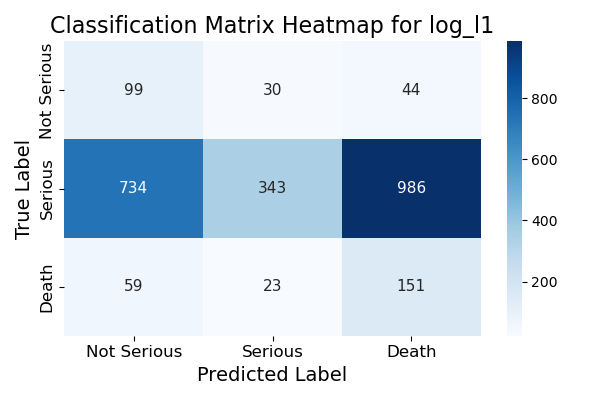

In [151]:
display(Image(filename=log_l1_img_path))

#### Other Model Metrics - Model Coefficient Odds for Each Outcome

In [152]:
def get_model_coefficients_and_odds(data, model_name, top_n=5):
    outcomes = ['Non-Serious', 'Serious', 'Death']
    result = {}

    for i, outcome in enumerate(outcomes):
        # Intercept
        intercept_data = {'Feature': ['Intercept'], 'LogOdds': [model_name.intercept_[i]]}
        intercept_df = pd.DataFrame(intercept_data)
        intercept_df['Odds'] = np.exp(intercept_df['LogOdds'])

        # Coefficients
        coef_data = {'Feature': data.columns, 'LogOdds': model_name.coef_[i]}
        coef_df = pd.DataFrame(coef_data)
        coef_df = coef_df.reindex(coef_df['LogOdds'].abs().sort_values(ascending=False).index)
        coef_df['Odds'] = np.exp(coef_df['LogOdds'])

        # Combine intercept and coefficients
        df = pd.concat([intercept_df, coef_df])
        
        result[outcome] = df.head(top_n + 1)

    return result

In [153]:
coefficients_and_odds = get_model_coefficients_and_odds(X_train_under, log_l1)
for outcome, df in coefficients_and_odds.items():
     print(f"Top features for {outcome}:")
     print(df)

Top features for Non-Serious:
     Feature   LogOdds      Odds
0  Intercept -0.739145  0.477522
2        sex  0.501394  1.651021
0     weight  0.374696  1.454549
1        age -0.363225  0.695430
Top features for Serious:
     Feature   LogOdds      Odds
0  Intercept  0.166579  1.181257
0     weight  0.000000  1.000000
1        age  0.000000  1.000000
2        sex  0.000000  1.000000
Top features for Death:
     Feature   LogOdds      Odds
0  Intercept  0.572566  1.772810
1        age  0.386343  1.471589
2        sex -0.310482  0.733093
0     weight -0.177861  0.837059


### Logistic Regression L2 Regularization

#### Generate and Fit Model on Training Data

In [154]:
log_l2 = LogisticRegression(solver='saga', penalty='l2', random_state=1)
log_l2.fit(X_train_under, y_train_under)

LogisticRegression(random_state=1, solver='saga')

#### Fit Model on Testing Data, Model Performance Metrics

In [208]:
model_name = 'log_l2'

# Run model on test data, generate confusion matrix, save y_pred
log_l2_metrics_df, log_l2_img_path, log_l2_y_pred = evaluate_model(log_l2, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

log_l2_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,log_l2,0,0.241,0.112,0.578,0.188,0.954
1,log_l2,1,0.241,0.868,0.166,0.279,0.171
2,log_l2,2,0.241,0.128,0.648,0.214,0.936


#### View Classification Matrix

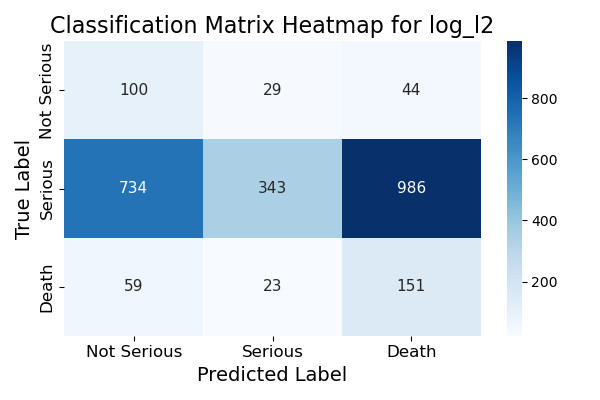

In [156]:
display(Image(filename=log_l2_img_path))

#### Other Metrics - Model Coefficient Odds for Each Outcome

In [157]:
coefficients_and_odds = get_model_coefficients_and_odds(X_train_under, log_l2)
for outcome, df in coefficients_and_odds.items():
     print(f"Top features for {outcome}:")
     print(df)

Top features for Non-Serious:
     Feature   LogOdds      Odds
0  Intercept -0.742522  0.475912
2        sex  0.439795  1.552388
1        age -0.371641  0.689602
0     weight  0.309955  1.363364
Top features for Serious:
     Feature   LogOdds      Odds
0  Intercept  0.166670  1.181364
0     weight -0.065439  0.936656
2        sex -0.063487  0.938486
1        age -0.007711  0.992319
Top features for Death:
     Feature   LogOdds      Odds
0  Intercept  0.575852  1.778646
1        age  0.379352  1.461337
2        sex -0.376307  0.686392
0     weight -0.244516  0.783083


### Logistic Regression Elastic Net

#### Grid Search

In [158]:
param_grid = {
    'l1_ratio': [i / 9 for i in range(10)],  # 10 values from 0 to 1 (0, 0.1, 0.2, ..., 1.0)
    'C': [0.01, 0.1, 1, 10, 100]  # Different strengths of regularization
}

# Initialize the Logistic Regression model with Elastic Net penalty
log_reg_elasticnet = LogisticRegression(
    penalty='elasticnet',  # Use Elastic Net regularization
    solver='saga',        # Solver that supports Elastic Net
    random_state=1
)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg_elasticnet,
    param_grid=param_grid,
    scoring='accuracy',   # Or another metric of choice
    cv=5,                 # Number of cross-validation folds
    n_jobs=-1              # Use all available CPUs
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_under, y_train_under.values.ravel())

# Extract and print the best parameters and best score from grid search
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

best_score = grid_search.best_score_
print(f"Best cross-validation score: {best_score:.3f}")

# Get the best model
elastic_net = grid_search.best_estimator_


Best parameters: {'C': 0.1, 'l1_ratio': 0.4444444444444444}
Best cross-validation score: 0.473


#### Generate and Fit Model on Training Data

In [159]:
elastic_net.fit(X_train_under, y_train_under)

LogisticRegression(C=0.1, l1_ratio=0.4444444444444444, penalty='elasticnet',
                   random_state=1, solver='saga')

#### Fit Model on Testing Data, Model Performance Metrics

In [210]:
model_name = 'elastic_net'

# Run model on test data, generate confusion matrix, save y_pred
elastic_net_metrics_df, elastic_net_img_path, elastic_net_y_pred = evaluate_model(elastic_net, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

elastic_net_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,elastic_net,0,0.239,0.112,0.584,0.188,0.954
1,elastic_net,1,0.239,0.873,0.163,0.275,0.171
2,elastic_net,2,0.239,0.128,0.652,0.215,0.937


#### View Classification Matrix

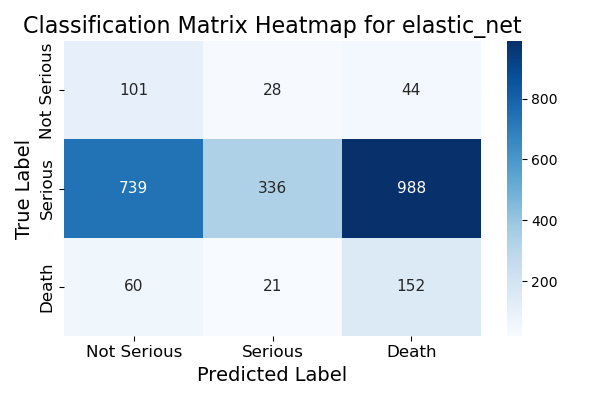

In [161]:
display(Image(filename=elastic_net_img_path))

#### Other Metrics - Model Coefficient Odds for Each Outcome

In [162]:
coefficients_and_odds = get_model_coefficients_and_odds(X_train_under, elastic_net)
for outcome, df in coefficients_and_odds.items():
     print(f"Top features for {outcome}:")
     print(df)

Top features for Non-Serious:
     Feature   LogOdds      Odds
0  Intercept -0.704522  0.494345
2        sex  0.477012  1.611254
0     weight  0.367301  1.443833
1        age -0.357128  0.699683
Top features for Serious:
     Feature   LogOdds      Odds
0  Intercept  0.158599  1.171868
0     weight  0.000000  1.000000
1        age  0.000000  1.000000
2        sex  0.000000  1.000000
Top features for Death:
     Feature   LogOdds      Odds
0  Intercept  0.545923  1.726200
1        age  0.380501  1.463017
2        sex -0.296318  0.743551
0     weight -0.171195  0.842657


### Single Decision Tree

#### Grid Search

In [164]:
# Define a grid of hyperparameters to search for in tree
param_grid = {
    'max_depth' : [5,6,7,8,9,10],
    'min_samples_leaf' : [1,2,3,4,5,6]
    
}
# Create a GridSearchCV object using and the defined parameter grid
tree1_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=10, n_jobs=-1)

# Fit the GridSearchCV to the balanced training data to find the best hyperparameters
tree1_search.fit(X_train_under, y_train_under.values.ravel())

# Get the best hyperparameters found by the GridSearch
best_params = tree1_search.best_params_
print(f"Best parameters: {best_params}")

tree1 = tree1_search.best_estimator_


Best parameters: {'max_depth': 7, 'min_samples_leaf': 3}


#### Generate and Fit Model on Training Data

In [165]:
tree1.fit(X_train_under, y_train_under)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=3, random_state=1)

#### Fit Model on Testing Data, Model Performance Metrics

In [212]:
model_name = 'tree1'

# Run model on test data, generate confusion matrix, save y_pred
tree1_metrics_df, tree1_img_path, tree1_y_pred = evaluate_model(tree1, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

tree1_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,tree1,0,0.346,0.126,0.607,0.208,0.958
1,tree1,1,0.346,0.867,0.303,0.450,0.177
2,tree1,2,0.346,0.136,0.532,0.217,0.930


#### View Classification Matrix

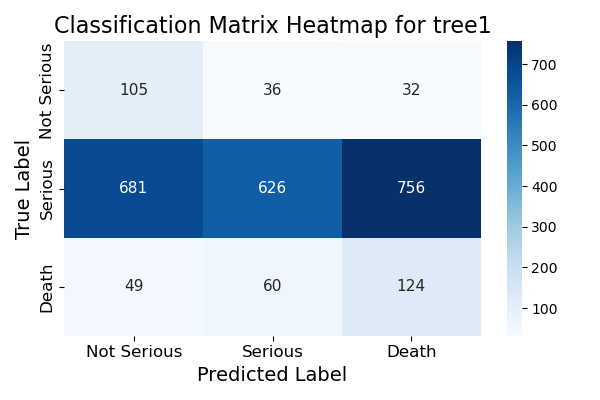

In [167]:
display(Image(filename=tree1_img_path))

#### Other Metrics - Feature Importance and Tree Structure

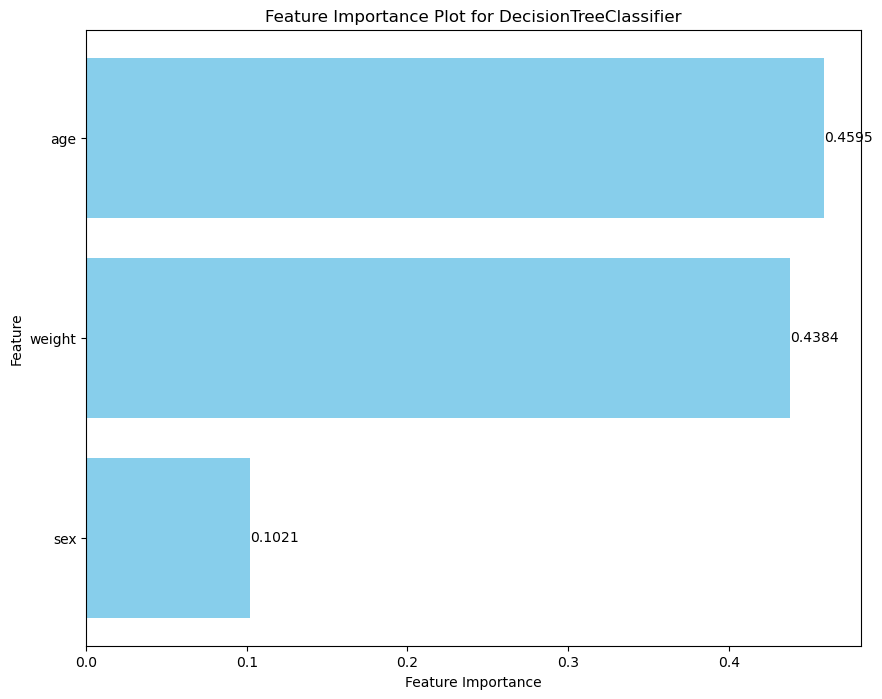

In [168]:
# Feature Importance Scores
# Extract feature importances
importances = tree1.feature_importances_
features = X_train_under.columns

# Create a DataFrame for better plotting
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot for DecisionTreeClassifier')
plt.gca().invert_yaxis()  # To display the most important feature at the top
# Add labels to the bars
for bar in bars:
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.4f}',
        va='center'
    )

plt.show()

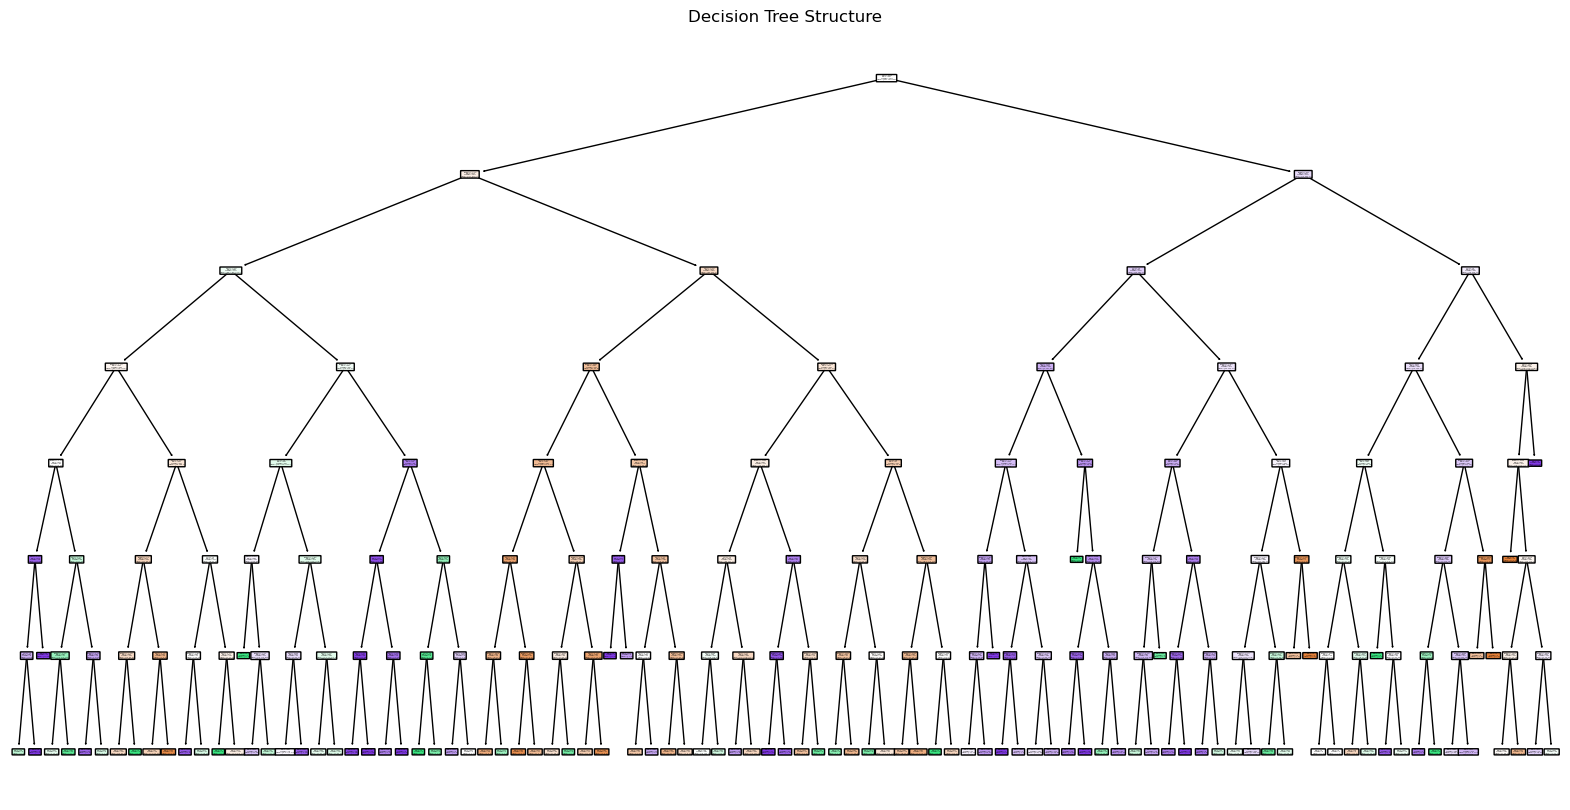

In [169]:
from sklearn.tree import plot_tree
# Plot the tree structure
plt.figure(figsize=(20, 10))
plot_tree(tree1, filled=True, feature_names=X_train_under.columns, class_names=['NonSerious', 'Serious', 'Death'], rounded=True)
plt.title('Decision Tree Structure')
plt.show()

## Ensembles

### Random Forest Classifier w/ 10-k CV

#### Grid Search

In [172]:
param_grid = {
    'n_estimators': [100, 125, 150, 175, 200]  # Example range for number of estimators
}

# Initialize the Random Forest Classifier
random_forest = RandomForestClassifier(random_state=1)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=random_forest,
                           param_grid=param_grid,
                           cv=5,  # Number of cross-validation folds
                           scoring='accuracy',  # Use accuracy as the scoring metric
                           n_jobs=-1,  # Use all available cores
                           verbose=2)  # Print progress messages

# Fit GridSearchCV to the data
grid_search.fit(X_train_under, y_train_under.values.ravel())

# Get the best model from the grid search
rf = grid_search.best_estimator_

rf.fit(X_train_under, y_train_under)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Example: Printing the best model parameters
print("Best Random Forest Model:")
print(rf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'n_estimators': 150}
Best Score: 0.4763051363051363
Best Random Forest Model:
RandomForestClassifier(n_estimators=150, random_state=1)


#### Fit Model on Testing Data, Model Performance Metrics

In [214]:
model_name = 'rf'

# Run model on test data, generate confusion matrix, save y_pred
rf_metrics_df, rf_img_path, rf_y_pred = evaluate_model(rf, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

rf_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,rf,0,0.364,0.100,0.509,0.167,0.947
1,rf,1,0.364,0.862,0.337,0.485,0.177
2,rf,2,0.364,0.147,0.494,0.226,0.930


#### View Classification Matrix

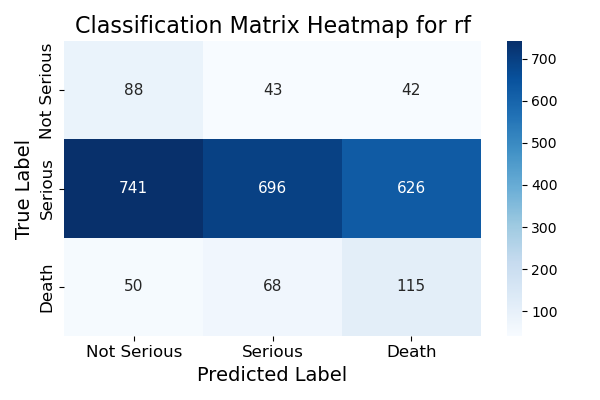

In [175]:
display(Image(filename=rf_img_path))

#### Other Metrics

In [176]:
# Get feature importance scores
importances=rf.feature_importances_
feature_importance_pairs=list(zip(X_train_under.columns, importances))

# Sort in descending order
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Print scores
print("Feature Importance Scores")
for feature, importance in sorted_feature_importance_pairs:
     print(f"{feature}: {importance:.4f}")

Feature Importance Scores
weight: 0.6220
age: 0.3625
sex: 0.0156


### Gradient Boosted Tree w/ 10-k CV

#### Grid Search

In [219]:
# Define a grid of hyperparameters to search for in the Gradient Boosting Classifier
param_grid = {
    'max_depth' : [5,6,7,8,9,10],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1],
    'n_estimators' : [50,75,100,125,150],
}
# Create a GridSearchCV object using GradientBoostingClassifier and the defined parameter grid
tree_search = GridSearchCV(GradientBoostingClassifier(random_state=1), param_grid, cv=10, n_jobs=-1)
# Fit the GridSearchCV to the balanced training data to find the best hyperparameters
tree_search.fit(X_train_under, y_train_under.values.ravel())
# Get the best hyperparameters found by the GridSearch
tree_search.best_params_

grboost = tree_search.best_estimator_


# Print the best parameters and the best score
print("Best Parameters:", tree_search.best_params_)
print("Best Score:", tree_search.best_score_)

# Example: Printing the best model parameters
print("Best Gradient Boosted Tree:")
print(grboost)


KeyboardInterrupt



#### Fit Model on Testing Data, Model Performance Metrics

In [ ]:
model_name = 'grboost'

# Run model on test data, generate confusion matrix, save y_pred
grboost_metrics_df, grboost_img_path, grboost_y_pred = evaluate_model(grboost, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

grboost_metrics_df.head()

In [ ]:
display_model_metrics_table(grboost_metrics_df)

#### View Classification Matrix

In [ ]:
display(Image(filename=grboost_img_path))

#### Other Metrics

In [ ]:
# Get feature importance scores
importances=grboost.feature_importances_
feature_importance_pairs=list(zip(X_train_under.columns, importances))

# Sort in descending order
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Print scores
print("Feature Importance Scores")
for feature, importance in sorted_feature_importance_pairs:
     print(f"{feature}: {importance:.4f}")

## Non-parametric

### K-Nearest Neighbors Classifier

#### Grid Search

In [221]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]  # Example range for number of neighbors
}

# Initialize the K-Nearest Neighbors Classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search_knn = GridSearchCV(estimator=knn,
                               param_grid=param_grid,
                               cv=5,  # Number of cross-validation folds
                               scoring='accuracy',  # Use accuracy as the scoring metric
                               n_jobs=-1,  # Use all available cores
                               verbose=2)  # Print progress messages

# Fit GridSearchCV to the data
grid_search_knn.fit(X_train_under, y_train_under.values.ravel())

# Get the best model from the grid search
knn = grid_search_knn.best_estimator_

# Print the best parameters and the best score
print("Best Parameters for KNN:", grid_search_knn.best_params_)
print("Best Score for KNN:", grid_search_knn.best_score_)

# Example: Printing the best model parameters
print("Best KNN Model:")
print(knn)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best Parameters for KNN: {'n_neighbors': 17}
Best Score for KNN: 0.4756621036621037
Best KNN Model:
KNeighborsClassifier(n_neighbors=17)


#### Fit Model on Testing Data, Model Performance Metrics

In [222]:
model_name = 'knn'

# Run model on test data, generate confusion matrix, save y_pred
knn_metrics_df, knn_img_path, knn_y_pred = evaluate_model(knn, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

knn_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,knn,0,0.348,0.117,0.613,0.197,0.957
1,knn,1,0.348,0.861,0.306,0.451,0.175
2,knn,2,0.348,0.146,0.519,0.227,0.932


#### View Classification Matrix

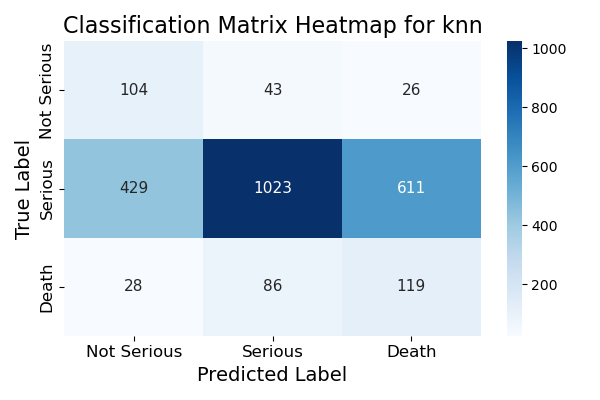

In [114]:
display(Image(filename=knn_img_path))

#### Other Metrics

### Neural Network

In [ ]:
# train

In [ ]:
# feature importance

In [ ]:
# 

# Performance Metrics Table

In [223]:
def display_model_metrics_table(metrics_dfs):
    # Concatenate all DataFrames
    combined_df = pd.concat(metrics_dfs, ignore_index=True)
    
    # Convert DataFrame to a list of lists for tabulate
    table = combined_df.values.tolist()
    
    # Get column headers from DataFrame
    headers = combined_df.columns.tolist()
    
    # Generate and print the table
    table_str = tabulate(table, headers, tablefmt='pretty')
    print(table_str)

In [225]:
display_model_metrics_table([log_l1_metrics_df, log_l2_metrics_df, elastic_net_metrics_df,
                           tree1_metrics_df, rf_metrics_df, knn_metrics_df])  # grboost_metrics_df

+-------------+-------+----------+-----------+--------+----------+-------------+
|    model    | class | accuracy | precision | recall | f1_score | specificity |
+-------------+-------+----------+-----------+--------+----------+-------------+
|   log_l1    |   0   |   0.24   |   0.111   | 0.572  |  0.186   |    0.953    |
|   log_l1    |   1   |   0.24   |   0.866   | 0.166  |  0.279   |    0.17     |
|   log_l1    |   2   |   0.24   |   0.128   | 0.648  |  0.214   |    0.936    |
|   log_l2    |   0   |  0.241   |   0.112   | 0.578  |  0.188   |    0.954    |
|   log_l2    |   1   |  0.241   |   0.868   | 0.166  |  0.279   |    0.171    |
|   log_l2    |   2   |  0.241   |   0.128   | 0.648  |  0.214   |    0.936    |
| elastic_net |   0   |  0.239   |   0.112   | 0.584  |  0.188   |    0.954    |
| elastic_net |   1   |  0.239   |   0.873   | 0.163  |  0.275   |    0.171    |
| elastic_net |   2   |  0.239   |   0.128   | 0.652  |  0.215   |    0.937    |
|    tree1    |   0   |  0.3